In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

import sys
import os as os 
from glob import glob
import shutil
import numpy as np

import scipy.io as io
import pandas as pd
import seaborn as sns

from nltk.corpus import wordnet as wn
import itertools
from itertools import product
from math import log

from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [2]:
from os.path import basename as bname
from os.path import dirname as dname

from tqdm import tqdm
from taskfunctions import flatten
from taskfunctions import loadimages
from taskfunctions import splitall

In [3]:
def im10k_data():
    '''Generates im10k (pandas Dataframe)\n
       rows = im_names\n
       cols= ['im_name', 'n_pic', 'dir', 'tags', 'vec']\n
       Parameter(s)\n
       ------------\n
       'imdir': top image folder ('images' in cnib)\n
       Variables\n
       ---------\n
       'impaths': list of all image paths (see 'taskfunctions.py')\n
       'im_names': list of all im_names, quantity of images in folder,\
                             folders paths\n
           i.e. 'body_part_dog_tail', 'body_beaver', 'face_bveaver',
                'shoe', 'male_teen' etc.
       'all_tags': ordered list of all possible unique tags\n
       'im10k': conversion of im_names to DF.
                   im10k['tags'].items()
       'matrix': numpy array of category membership for all images
                 For each image, category membership is represented by 1 or 0
                 (1=Category name in path parts; else 0)
       'imdf': conversion from array to DataFrame to create vectors (as rows)\
               for each image\n
       Returns\n
       -------
       'cnib'\n
       *new columns added during execution:\n
           'tags': lists all folders' names (categories) in imdir\n
            'vec': tuple where each boolean value represents\
            category membership\n
            *categories are ordered as 'all_tags'\n
        DATA ACCESS\n
            cnib.loc['concept_name']['datas']['npic', 'dir', 'tags', 'vec']
    '''
    imdir = '../images'
    def get_data():
        impaths = loadimages(imdir)
        im_names = []
        for impath in impaths:
            if 'object' in impath:
                name = bname(dname(impath))
            else:
                name = bname(dname(impath))+' '+\
                                            bname(dname(dname(impath)))
            im_names.append((name, len(os.listdir(dname(impath))),
                             dname(impath)))
        im_names = sorted(list(dict.fromkeys(list(im_names))))
        im10k = pd.DataFrame(im_names, columns=['im_name', 'n_pic', 'dir'])
        im10k.index = im10k.im_name
        im10k['tags'] = [splitall(folderpath[1].split(imdir,
                                                      maxsplit=1)[1])[1:]
                         for folderpath in im10k['dir'].items()]
        all_tags = sorted(list(dict.fromkeys(flatten([tags[1]
                                                      for tags in \
                                                      im10k['tags'].items()]))))
        matrix = np.array([[bool(tags[1].__contains__(tag))
                            for tag in all_tags]
                           for tags in im10k['tags'].items()])
        imdf = pd.DataFrame(matrix, index=im10k['im_name'],
                            columns=all_tags)
        im10k['vec'] = list(row[1] for row in imdf.iterrows())
        im10k = im10k.drop(columns='im_name')
        return im10k
    def categories(im10k, kword):
        '''Categorizes the DF according to neuromod categories using "tags"'''
        return pd.DataFrame([im10k.loc[row[0]]
                             for row in im10k.iterrows()
                             if kword in im10k.loc[row[0]].tags])
    im10k = get_data()
    alltags = sorted(list(dict.fromkeys(flatten(list(im10k.tags)))))
    cnib = pd.DataFrame(zip(alltags, list(categories(im10k, ind)
                                          for ind in tqdm(alltags))),
                        index=alltags, columns=['categories', 'data'])
    cnib = cnib.drop(columns=['categories'])
    return cnib

In [4]:
# data from THINGS
xls = pd.ExcelFile('CogNeuroModels.xlsx')
df_things_data = xls.parse('THINGS')

# sensory-mootor features
xls = pd.ExcelFile('CogNeuroModels.xlsx')
df_LSN_data = xls.parse('LSN')

FileNotFoundError: [Errno 2] No such file or directory: 'CogNeuroModels.xlsx'

### Get all the concepts

In [5]:
cnib = im10k_data()

100%|██████████| 411/411 [00:44<00:00,  9.15it/s]


In [6]:
# example of the structure
cnib.loc['animate']['data']

,n_pic,dir,tags,vec
adult female,149,../images/animate/human/face/female/adult,"[animate, human, face, female, adult]",MRI False RV Fa...
adult male,104,../images/animate/human/face/male/adult,"[animate, human, face, male, adult]",MRI False RV Fa...
arm human,20,../images/animate/human/arm,"[animate, human, arm]",MRI False RV Fa...
baby female,9,../images/animate/human/face/female/baby,"[animate, human, face, female, baby]",MRI False RV Fa...
baby male,20,../images/animate/human/face/male/baby,"[animate, human, face, male, baby]",MRI False RV Fa...
...,...,...,...,...
tooth monkey,4,../images/animate/animal/mammal/monkey/tooth,"[animate, animal, mammal, monkey, tooth]",MRI False RV Fa...
tooth rabbit,1,../images/animate/animal/mammal/rabbit/tooth,"[animate, animal, mammal, rabbit, tooth]",MRI False RV Fa...
tooth seal,1,../images/animate/animal/mammal/aquatic_mammal...,"[animate, animal, mammal, aquatic_mammal, seal...",MRI False RV Fa...
tooth tiger,6,../images/animate/animal/mammal/feline/tiger/t...,"[animate, animal, mammal, feline, tiger, tooth]",MRI False RV Fa...


### Check out distribution across categories

In [7]:
n_animate = cnib.loc['animate']['data']['n_pic'].sum()  
n_inanimate = cnib.loc['object']['data']['n_pic'].sum()  
print('we have a total of ',n_animate+n_inanimate, ' images')
print('of which ',n_animate, ' are animate')
print('while ',n_inanimate, ' inanimate')

we have a total of  10198  images
of which  4646  are animate
while  5552  inanimate


In [8]:
n_subcat_animate = cnib.loc['animate']['data'].index.shape[0]
n_subcat_inanimate = cnib.loc['object']['data'].index.shape[0]
print('divided in a total of ',n_subcat_animate+n_subcat_inanimate, ' subcategories')
print('of which ',n_subcat_animate, ' are animate')
print('while ',n_subcat_inanimate, ' inanimate')

divided in a total of  537  subcategories
of which  255  are animate
while  282  inanimate


In [9]:
all_tags = np.hstack((np.unique(np.hstack([np.array(x) for x in cnib.loc['animate']['data']['tags'].values])),
                            np.unique(np.hstack([np.array(x) for x in cnib.loc['object']['data']['tags'].values]))))
df_unique = pd.DataFrame(all_tags,columns=['Word'])
print('we have a total of ', df_unique.shape[0], ' tags')

we have a total of  411  tags


In [10]:
all_tag_count = []
for tag_now in range(len(all_tags)): 
    n_tag = []
   
    # animate tags
    for nowcheck in range(len(cnib.loc['animate']['data']['tags'])):
        if all_tags[tag_now] in cnib.loc['animate']['data']['tags'][nowcheck]:
            n_tag.append(cnib.loc['animate']['data']['n_pic'][nowcheck])

    # inanimate tags
    for nowcheck in range(len(cnib.loc['object']['data']['tags'])):
        if all_tags[tag_now] in cnib.loc['object']['data']['tags'][nowcheck]:
            n_tag.append(cnib.loc['object']['data']['n_pic'][nowcheck])        
    
    #print('the tag ',all_tags[tag_now] ,' appears for ',sum(n_tag),' images')
    all_tag_count.append(sum(n_tag))
df_unique['n_pic']=all_tag_count

distribution across tags:


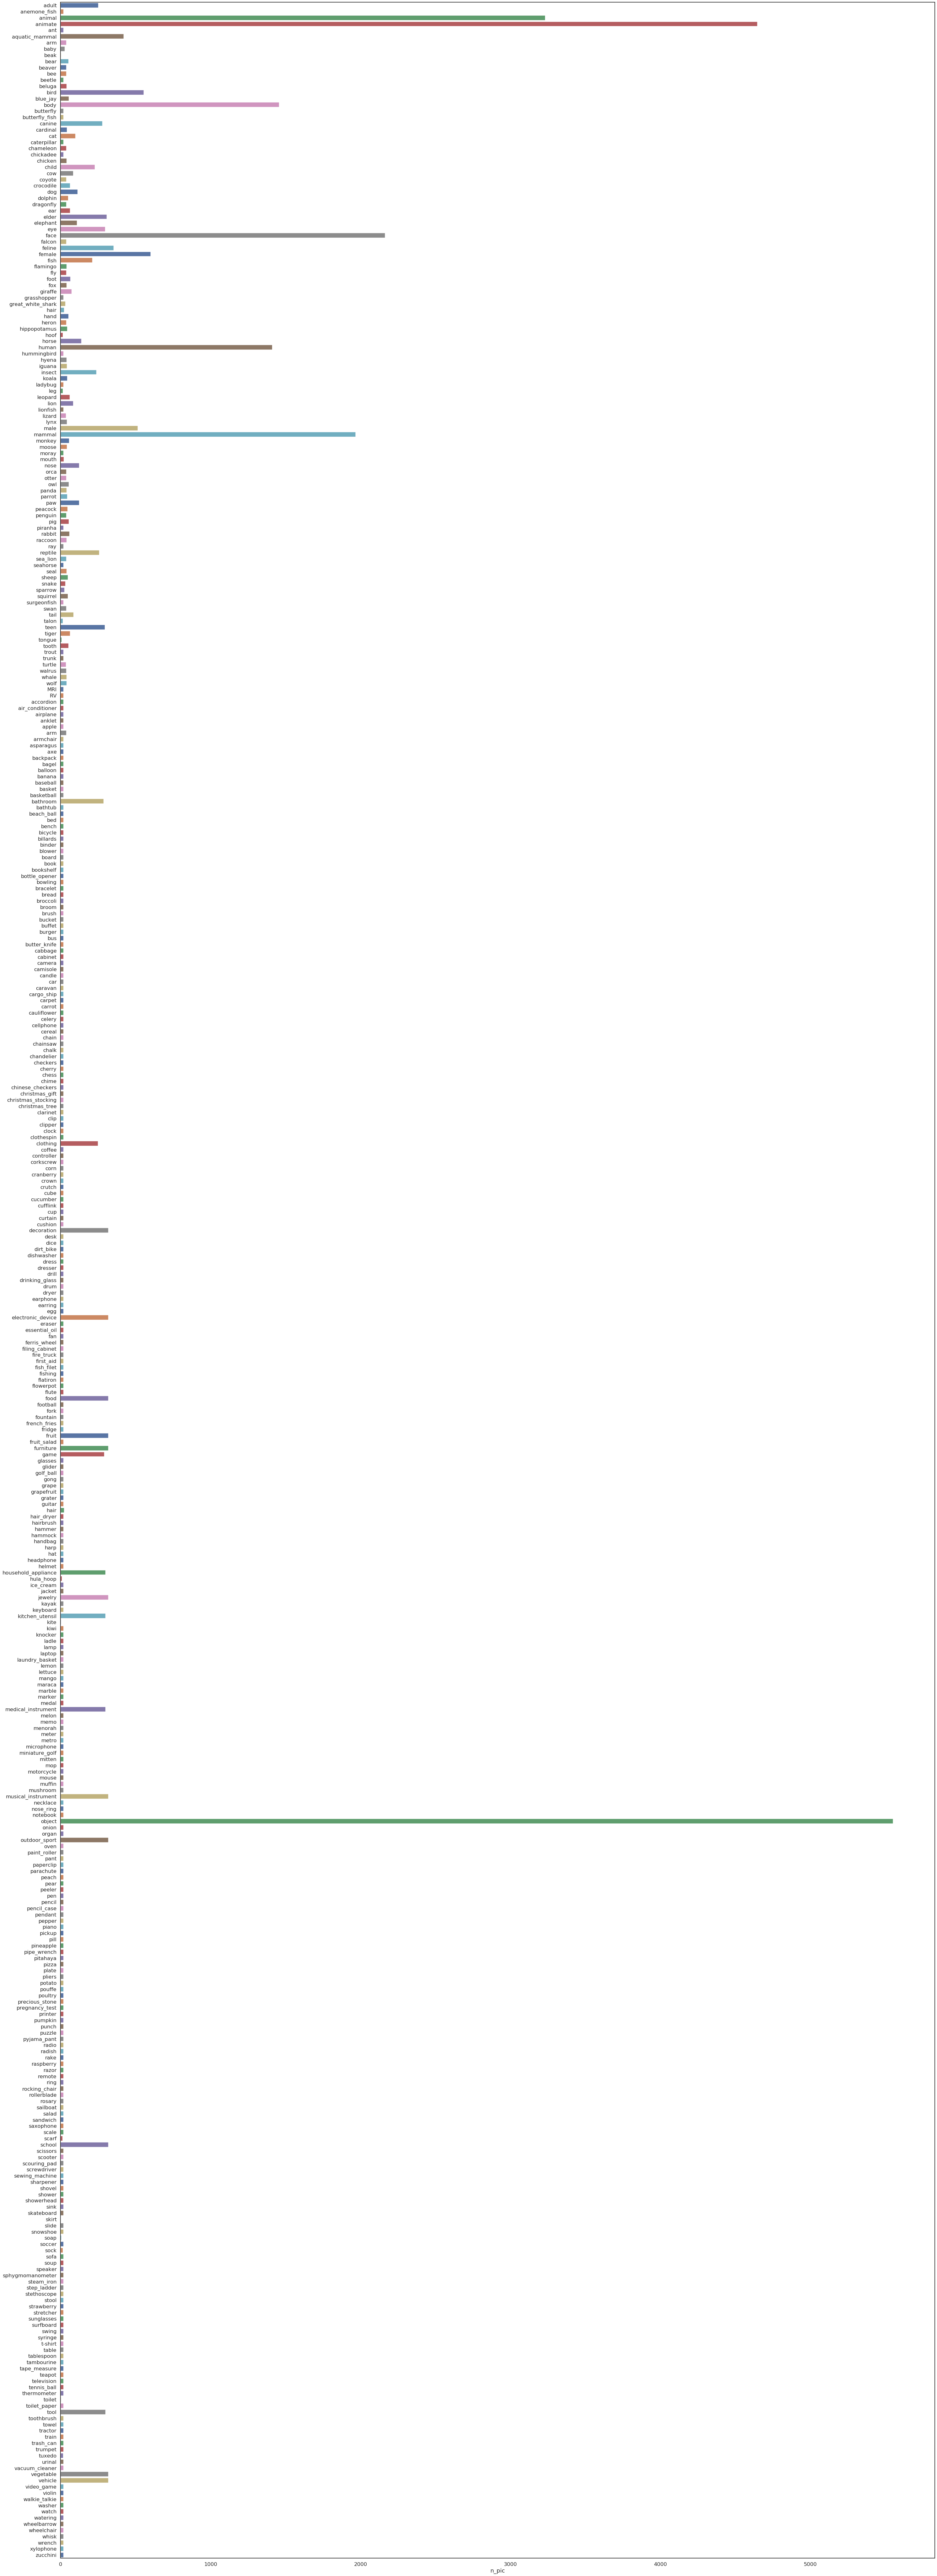

In [11]:
print('distribution across tags:')

sns.set(style="white", context="talk")

f, ax1 = plt.subplots(1, 1, figsize=(50,150))
sns.barplot(x=df_unique['n_pic'],
            y=np.arange(0,len(df_unique['Word'])), 
            palette="deep", ax= ax1, orient='h')
plt.yticks(np.arange(0,len(df_unique['Word'])),df_unique['Word'].values) 

plt.show()

In [12]:
all_concepts = list(cnib.loc['animate']['data'].index) + list(cnib.loc['object']['data'].index)
print('if we consider a total of ',len(all_concepts),' concepts')

if we consider a total of  537  concepts


In [13]:
all_concepts_in_THINGS = df_things_data[df_things_data['Word'].isin(all_concepts)]
print('we can find ',len(all_concepts_in_THINGS),' of them in THINGS')

we can find  201  of them in THINGS


In [14]:
all_concepts_in_THINGS_clean = all_concepts_in_THINGS[all_concepts_in_THINGS['Wordnet ID4'].notna()]
print('All our concepts that are in THINGS and have Wordnet ID:', all_concepts_in_THINGS_clean.shape[0])

All our concepts that are in THINGS and have Wordnet ID: 199


### compute similarity based on wordnet synset 

In [15]:
sim_mat_wn = np.zeros((len(all_concepts_in_THINGS_clean),len(all_concepts_in_THINGS_clean)))
for j in range(0,len(all_concepts_in_THINGS_clean)):
    for k in range(0,len(all_concepts_in_THINGS_clean)): 
        s1 = wn.synset(all_concepts_in_THINGS_clean['Wordnet ID4'].values[j])
        s2 = wn.synset(all_concepts_in_THINGS_clean['Wordnet ID4'].values[k])
        sim_mat_wn[j,k] =  wn.wup_similarity(s1, s2)
        sim_mat_wn[k,j] =  wn.wup_similarity(s1, s2)

### compute t-SNE based on wordnet similarity 

In [16]:
X_wn = 1-(sim_mat_wn)
TSNE = manifold.TSNE(perplexity=30,metric='precomputed', random_state=0)
X_wn_TSNE = TSNE.fit_transform(X_wn)

### plot similarity matrix and t-SNE results 

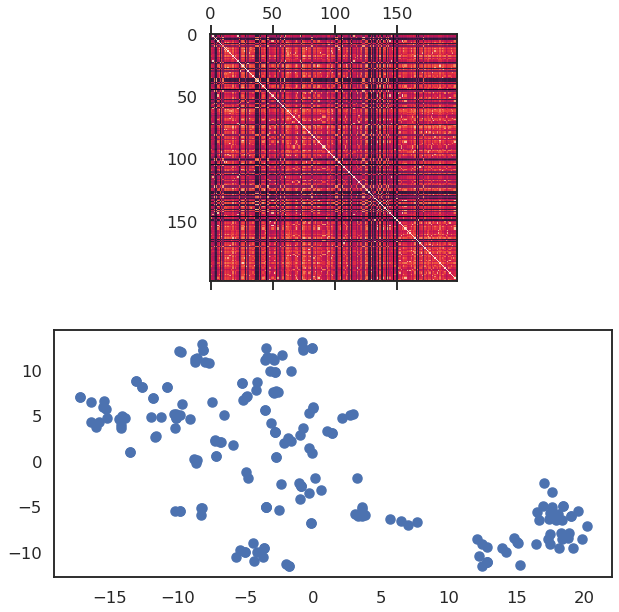

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.matshow(sim_mat_wn) 
ax2.scatter(X_wn_TSNE[:, 0], X_wn_TSNE[:, 1])  
#ax2.set_title('WN TSNE',fontsize= 20)
plt.show()

In [18]:
# Top-down Category (WordNet)
# All Bottom-up Categories
labels_feat = []
for w in range(len(all_concepts_in_THINGS_clean['Top-down Category (WordNet)'])):
    labels_feat.append(all_concepts_in_THINGS_clean['Top-down Category (WordNet)'].values[w])
le = LabelEncoder()
labels_feat_cat = le.fit_transform(labels_feat)

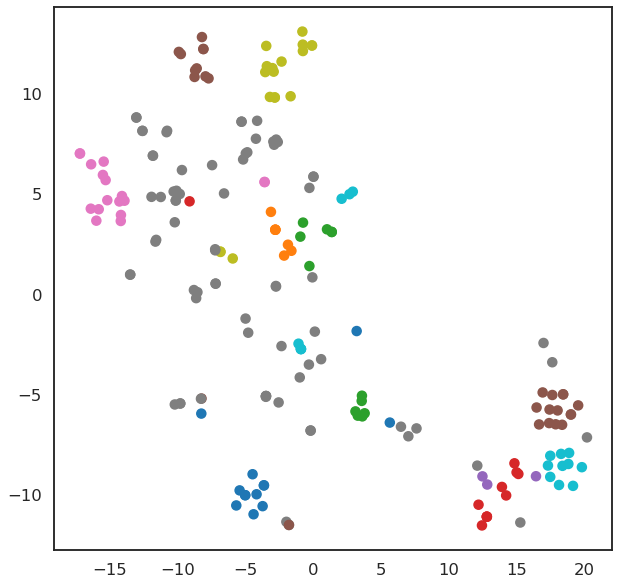

In [19]:
# plot with color = categories from WordNet
colors_feat = cm.tab10(np.linspace(0, 1, len(np.unique(labels_feat_cat))))
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
ax1.scatter(X_wn_TSNE[:, 0], X_wn_TSNE[:, 1],
            c=colors_feat[labels_feat_cat[:]])  
plt.show()